# Imports

In [1]:
from src.utils import *
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import time

import statsmodels.formula.api as smf

# The Bootstrap

In [2]:
# Sample Multinomial Distribution

N = 10_000
np.random.seed(1)
bootstrap_weights = np.random.multinomial(N, np.ones(N)/N)
np.sum(bootstrap_weights)

10000

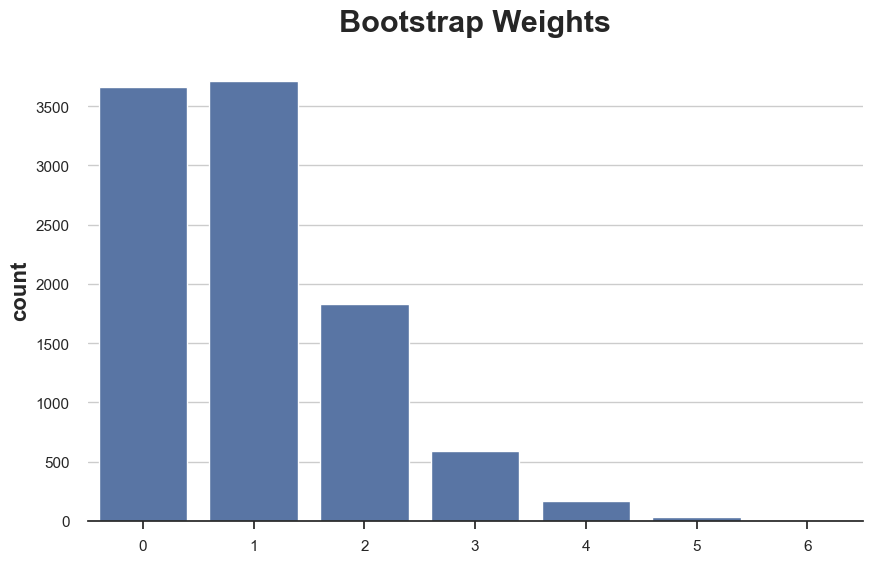

In [3]:
sns.countplot(bootstrap_weights, color='C0').set(title='Bootstrap Weights');

As we can see, around 3600 observations got zero weight, while a couple of observations got a weight of 6. Or equivalently, around 3600 observations did not get re-sampled, while a couple of observations were sampled as many as 6 times.

Now you might have a spontaneous question: why not use continuous weights instead of discrete ones?

Very good question! The Bayesian Bootstrap is the answer.

# The Bayesian Bootstrap

The Bayesian bootstrap was introduced by Rubin (1981) and it’s based on a very simple idea: why not draw a smoother distribution of weights? The continuous equivalent of the multinomial distribution is the Dirichlet distribution.

The Bayesian Bootstrap has many advantages.

- The first and most intuitive one is that it delivers estimates that are much more smooth than the normal bootstrap, because of its continuous weighting scheme.
- Moreover, the continuous weighting scheme prevents corner cases from emerging, since no observation will ever receive zero weight. For example, in linear regression, no problem of collinearity emerges, if there wasn’t one in the original sample.
- Lastly, being a Bayesian method, we gain interpretation: the estimated distribution of the estimator can be interpreted as the posterior distribution with an uninformative prior.

In [4]:
bayesian_weights = np.random.dirichlet(alpha=np.ones(N), size=1)[0] * N
np.sum(bayesian_weights)

10000.000000000005

The weights naturally sum to (approximately) 1, so we have to scale them by a factor N.

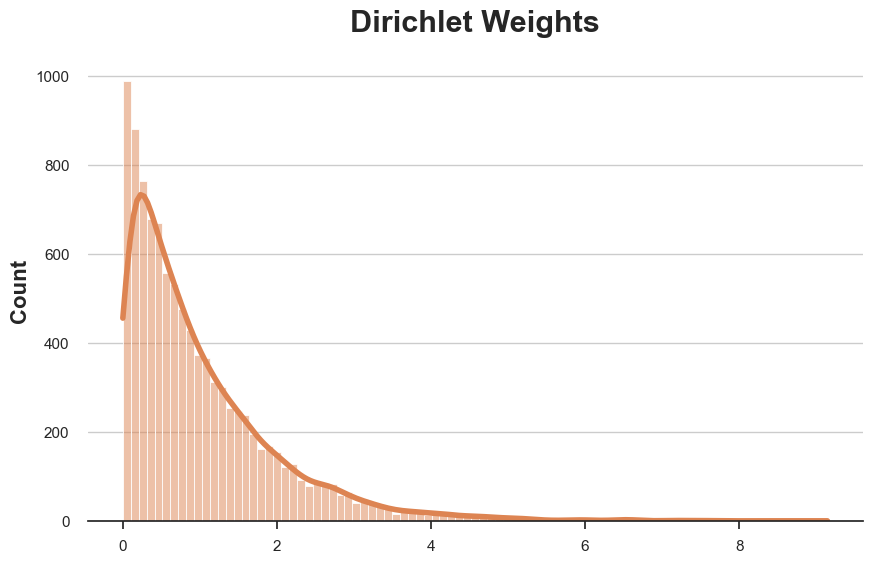

In [5]:
sns.histplot(bayesian_weights, color='C1', kde=True).set(title='Dirichlet Weights');

The α parameter essentially governs both the absolute and relative probability of being sampled. Increasing α for all observations makes the distribution less skewed so that all observations have a more similar weight. For α→∞, all observations receive the same weight and we are back to the original sample.

How should we select the value of α? Shao and Tu (1995) suggest the following.

> The distribution of the random weight vector does not have to be restricted to the Diri(l, … , 1). Later investigations found that the weights having a scaled Diri(4, … ,4) distribution give better approximations (Tu and Zheng, 1987)

Let’s have a look at how a Dirichlet distribution with α=4 for all observations compares to our previous distribution with α=1 for all observations.

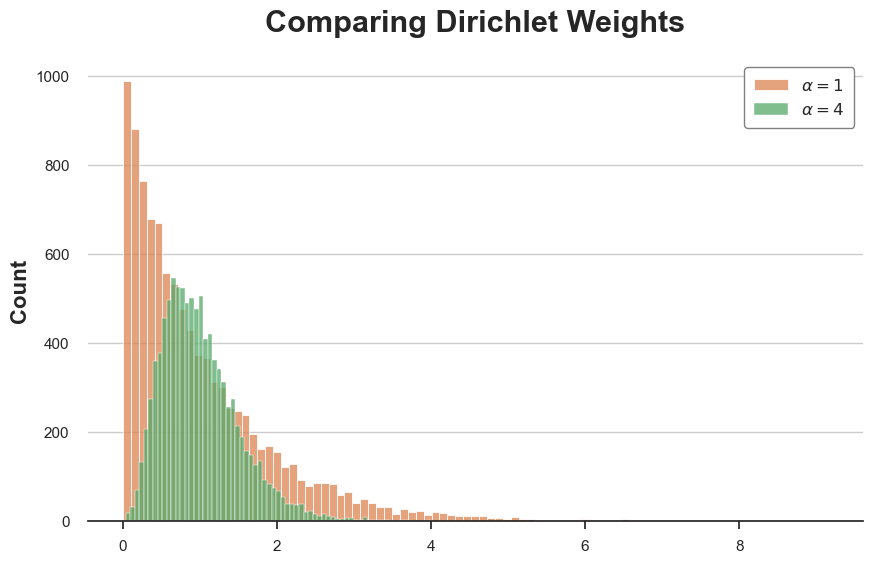

In [6]:
bayesian_weights2 = np.random.dirichlet(alpha=np.ones(N)*4, size=1)[0] * N
sns.histplot(bayesian_weights, color='C1')
sns.histplot(bayesian_weights2, color='C2').set(title='Comparing Dirichlet Weights');
plt.legend([r'$\alpha = 1$', r'$\alpha = 4$']);

# Examples

### Mean of a Skewed Distribution

First, let’s have a look at one of the simplest and most common estimators: the sample mean. First, let’s draw 100 observations from a Pareto distribution.

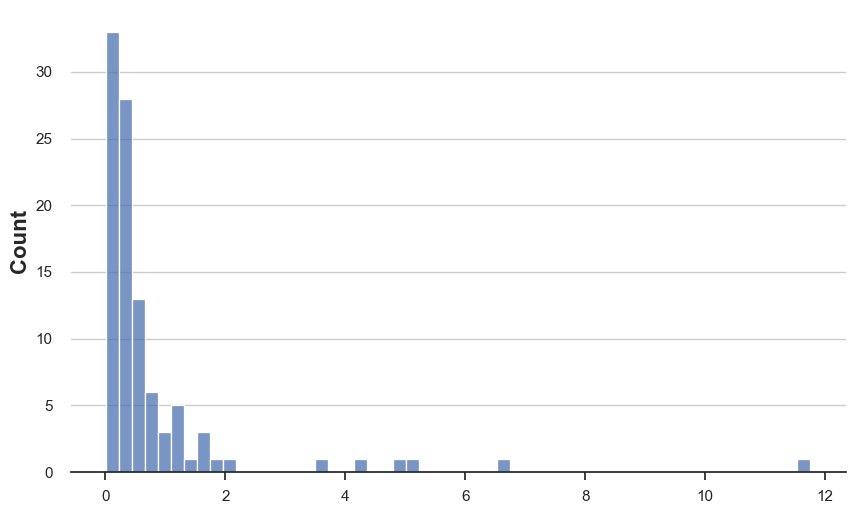

In [7]:
np.random.seed(2)
X = pd.Series(np.random.pareto(2, 100))
sns.histplot(X);

In [8]:
# Functions for classic and Bayesian bootstrapping

def classic_boot(df, estimator, seed=1):
    df_boot = df.sample(n=len(df), replace=True, random_state=seed)
    estimate = estimator(df_boot)
    return estimate


def bayes_boot(df, estimator, seed=1):
    np.random.seed(seed)
    w = np.random.dirichlet(np.ones(len(df)), 1)[0]
    result = estimator(df, weights=w)
    return result

In [9]:
# Function for parallelize the computation

def bootstrap(boot_method, df, estimator, K):
    r = Parallel(n_jobs=8)(delayed(boot_method)(df, estimator, seed=i) for i in range(K))
    return r

In [10]:
# Function for comparing results

def compare_boot(df, boot1, boot2, estimator, title, K=1000):
    s1 = bootstrap(boot1, df, estimator, K)
    s2 = bootstrap(boot2, df, estimator, K)
    df = pd.DataFrame({'Estimate': s1 + s2,
                       'Estimator': ['Classic']*K + ['Bayes']*K})
    sns.histplot(data=df, x='Estimate', hue='Estimator')
    plt.legend([f'Bayes:   {np.mean(s2):.2f} ({np.std(s2):.2f})',
                f'Classic: {np.mean(s1):.2f} ({np.std(s1):.2f})'])
    plt.title(f'Bootstrap Estimates of {title}')

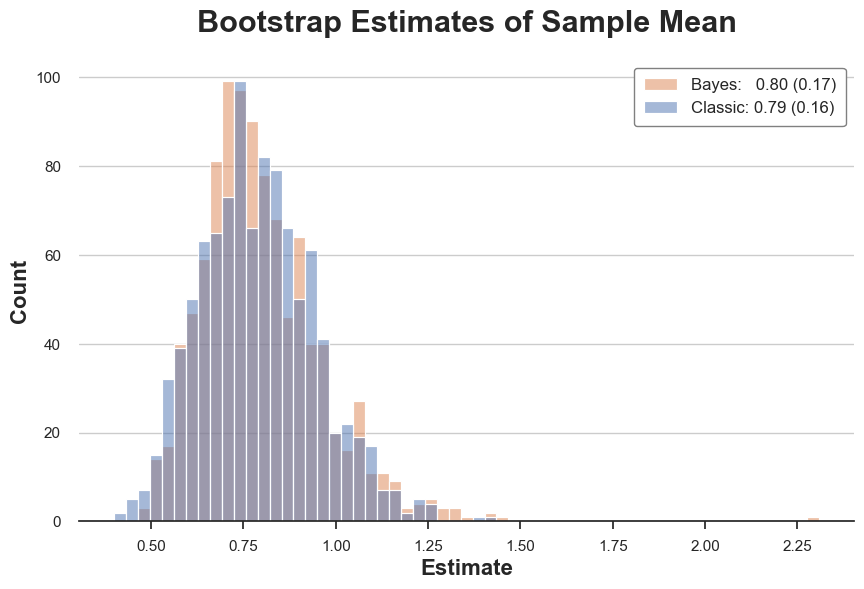

In [11]:
compare_boot(X, classic_boot, bayes_boot, np.average, 'Sample Mean')

In [12]:
# Function for comparing the time taken

def compare_time(df, boot1, boot2, estimator, K=1000):
    t1, t2 = np.zeros(K), np.zeros(K)
    for k in range(K):
        
        # Classic bootstrap
        start = time.time()
        boot1(df, estimator)
        t1[k] = time.time() - start
    
        # Bayesian bootstrap
        start = time.time()
        boot2(df, estimator)
        t2[k] = time.time() - start
    
    print(f"Bayes wins {np.mean(t1 > t2)*100}% of the time (by {np.mean((t1 - t2)/t1*100):.2f}%)")
    
    return t1, t2

In [13]:
t1, t2 = compare_time(X, classic_boot, bayes_boot, np.average)

Bayes wins 28.9% of the time (by nan%)


### Case of No Weighting

What if we have an estimator that does not accept weights, such as the median? We can do two-level sampling: first we sample the weights and then we sample observations according to the weights.

In [14]:
# Function for two-level sampling

def twolv_boot(df, estimator, seed=1):
    np.random.seed(seed)
    w = np.random.dirichlet(np.ones(len(df))*4, 1)[0]
    df_boot = df.sample(n=len(df)*10, replace=True, weights=w, random_state=seed)
    result = estimator(df_boot)
    return result

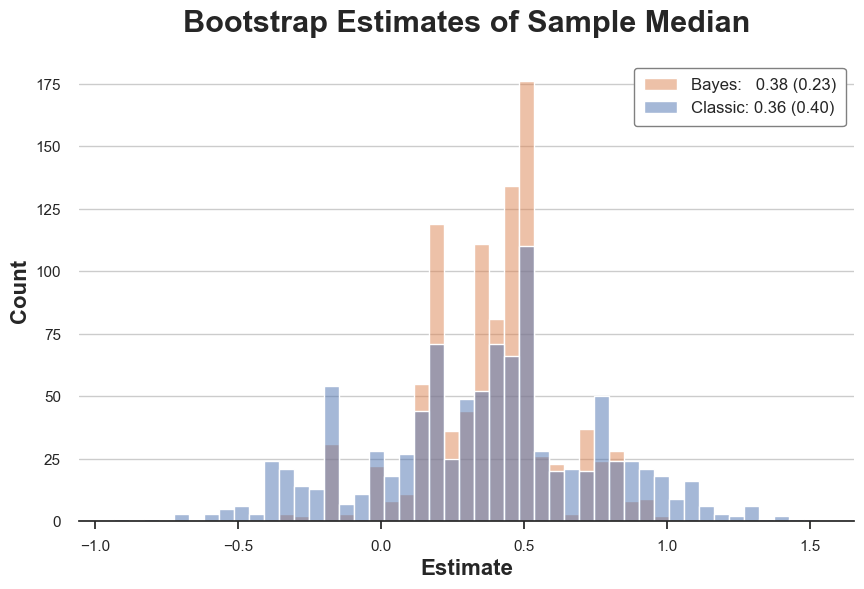

In [15]:
np.random.seed(1)
X = pd.Series(np.random.normal(0, 10, 1000))
compare_boot(X, classic_boot, twolv_boot, np.median, "Sample Median")

### Logistic Regression with Rare Outcome

Let’s now explore the first of two settings in which the classical bootstrap might fall into corner cases. Suppose we observed a feature x, normally distributed, and a binary outcome y. We are interested in the relationship between the two variables.

In [16]:
N = 100
np.random.seed(1)
x = np.random.normal(0, 1, N)
y = np.rint(np.random.normal(x, 1, N) > 2)
df = pd.DataFrame({'x': x, 'y': y})
df.head()

,x,y
0,1.624345,0.0
1,-0.611756,0.0
2,-0.528172,0.0
3,-1.072969,0.0
4,0.865408,0.0


In [17]:
smf.logit('y ~ x', data=df).fit(disp=False).summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-4.0955,0.887,-4.618,0.000,-5.834,-2.357
x,2.7664,0.752,3.677,0.000,1.292,4.241


In [18]:
estimate_logit = lambda df: smf.logit('y ~ x', data=df).fit(disp=False).params[1]
for i in range(1000):
    try:
        classic_boot(df, estimate_logit, seed=i)
    except Exception as e:
        print(f'Error for bootstrap number {i}: {e}')

Error for bootstrap number 92: Perfect separation detected, results not available
Error for bootstrap number 521: Perfect separation detected, results not available
Error for bootstrap number 545: Perfect separation detected, results not available
Error for bootstrap number 721: Perfect separation detected, results not available
Error for bootstrap number 835: Perfect separation detected, results not available


For 5 samples out of 1000, we are unable to compute the estimate. This would not have happened with the Bayesian bootstrap.

This might seem like an innocuous issue in this case: we can just drop those observations. Let’s conclude with a much more dangerous example.

### Regression with few Treated Units

In [19]:
N = 100
np.random.seed(1)
x = np.random.binomial(1, 5/N, N)
y = np.random.normal(1 + 2*x, 1, N)
df = pd.DataFrame({'x': x, 'y': y})
df.head()

,x,y
0,0,1.315635
1,0,-1.022201
2,0,0.693796
3,0,1.827975
4,0,1.230095


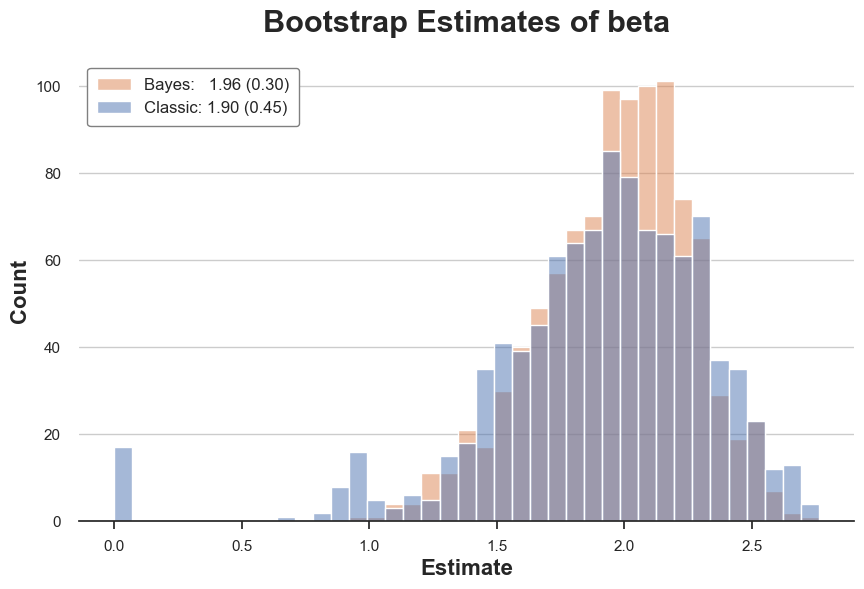

In [20]:
estimate_beta = lambda df, **kwargs: smf.wls('y ~ x', data=df, **kwargs).fit().params[1]
compare_boot(df, classic_boot, bayes_boot, estimate_beta, "beta")

# Conclusion

In this article, we have seen a powerful extension of the bootstrap: the **Bayesian bootstrap**. The key idea is that whenever our estimator can be expressed as a weighted estimator, the bootstrap is equivalent to random weighting with multinomial weights. The Bayesian bootstrap is equivalent to weighting with Dirichlet weights, the continuous equivalent of the multinomial distribution. Having continuous weights avoids corner cases and can generate a smoother distribution of the estimator.